# South African Language Identification Hack 2023

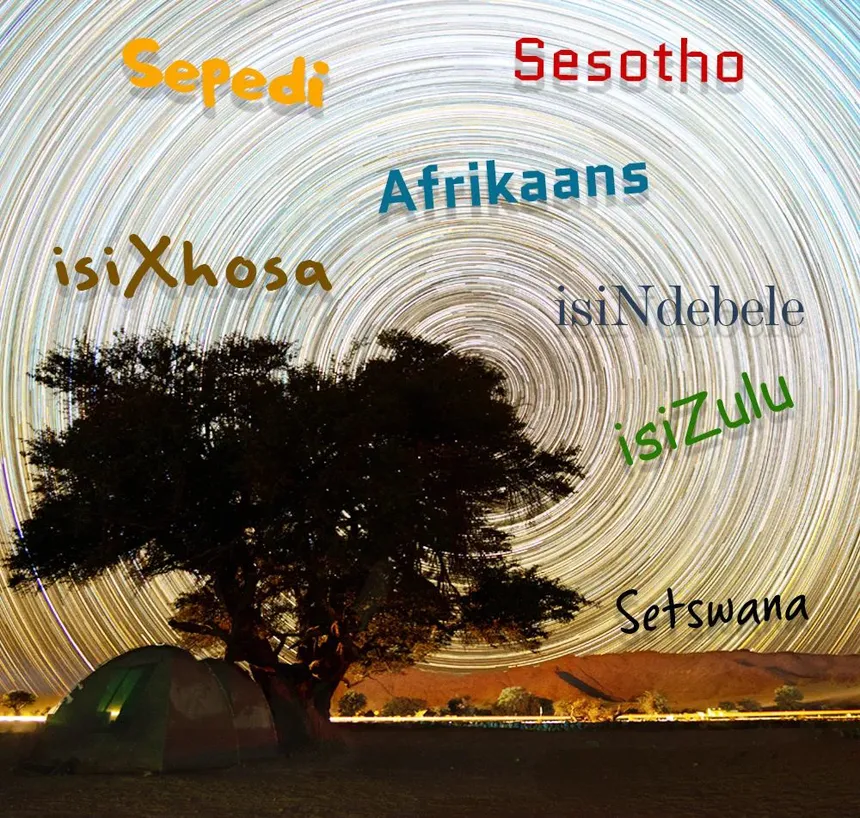

## Introduction 

South Africa boasts a diverse society with various languages, seen as a crucial element in enhancing democracy and contributing to its societal, cultural, economic, and political aspects. With 11 official languages holding equal status, most South Africans are multilingual, capable of speaking multiple languages. Given this linguistic diversity, it's essential for systems and devices to support communication in multiple languages. The challenge involves identifying the language of a text among South Africa's 11 official languages, representing a task in Natural Language Processing (NLP) called Language Identification.

#### Language IDs
- afr - Afrikaans
- eng - English
- nbl - isiNdebele
- nso - Sepedi
- sot - Sesotho
- ssw - siSwati
- tsn - Setswana
- tso - Xitsonga
- ven - Tshivenda
- xho - isiXhosa
- zul - isiZulu

## Importing Packages

In [25]:
# Packages for data analysis
import pandas as pd
import numpy as np
import time

# Packages for visualizations
import seaborn as sns
import matplotlib.style as style

# Packages for preprocessing
import nltk
import string
import re

# Packages for training models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


from sklearn.feature_extraction.text import TfidfVectorizer

# Model Evaluation Packages
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
%matplotlib inline

# Library For handling warnings:
import warnings

warnings.filterwarnings('ignore')



In [26]:
# vader_lexicon downloader
nltk.download('vader_lexicon')  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MashotoG\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Loading the Data

In [27]:
# importing the dataset
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

##  Looking into EDA

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [29]:
# viewing the text column

print(train['text'].head(7)) 

0    umgaqo-siseko wenza amalungiselelo kumaziko ax...
1    i-dha iya kuba nobulumko bokubeka umsebenzi na...
2    the province of kwazulu-natal department of tr...
3    o netefatša gore o ba file dilo ka moka tše le...
4    khomishini ya ndinganyiso ya mbeu yo ewa maana...
5    dinyakišišo tše tša go dirwa gabedi ka ngwaga ...
6    kgetse nngwe le nngwe e e sa faposiwang mo tsh...
Name: text, dtype: object


In [30]:
#checking for value counts and imbalances

train.lang_id.value_counts() 

lang_id
xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: count, dtype: int64

In [31]:
# checking null values 

train.isna().sum()

lang_id    0
text       0
dtype: int64

<Axes: xlabel='lang_id', ylabel='count'>

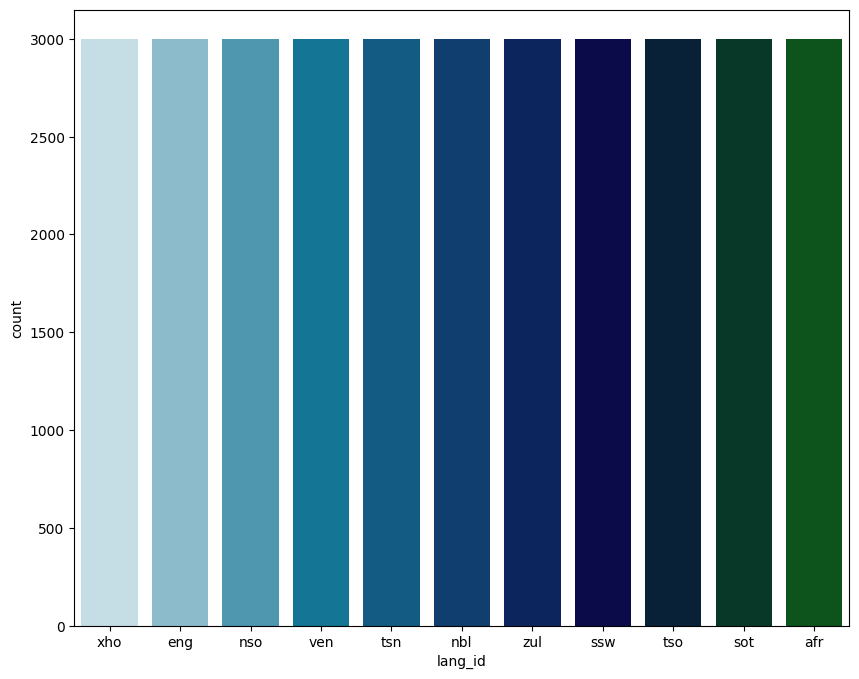

In [32]:
# Set the size of the figure for the plot
plt.figure(figsize=(10, 8))  
# Create a count plot using Seaborn
sns.countplot(x='lang_id', data=train, palette='ocean_r')

#### EDA observations

- There are no missing values
- The dataset has 33 000 rows and 2 columns
- Dataset is perfectly balanced so we do not have to make use of resampling techniques.
- Next we will preprocess the data

## PreProcessing and Data Cleaning

In [33]:
'''
function to clean our data
removing punctuation
extra spaces
changing words to lower case
spliting the texts
''' 

def clean_text(text):
    text=re.sub('<.*?>', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub("\n"," ",text)
    text = text.lower()
    text=' '.join(text.split())
    return text

train.head(10)

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
5,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga ...
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...


In [34]:
# Replace '.txt' with 'text file'
train["text"] = train["text"].str.replace(".txt", " text file")
test["text"] = test["text"].str.replace(".txt", " text file")

In [35]:
# Application of the function to clean the tweets
train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

## Modelling



In [36]:
#splitting data into features and labels
X = train["text"]
y = train["lang_id"]

In [37]:
#split  data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

In [41]:
# Define a function that calculates and prints F1 scores and execution time for a model
def calculate_and_print_metrics(y_true, y_pred, run_time):
    # Calculate F1 scores for different averaging methods
    F1_Macro = metrics.f1_score(y_true, y_pred, average='macro')  # Calculate F1 score using macro averaging
    F1_Accuracy = metrics.f1_score(y_true, y_pred, average='micro')  # Calculate F1 score using micro averaging
    F1_Weighted = metrics.f1_score(y_true, y_pred, average='weighted')  # Calculate F1 score using weighted averaging
    
    # Print F1 scores for different averaging methods
    print("F1 Macro:", F1_Macro)  # Display F1 score calculated using macro averaging
    print("F1 Accuracy:", F1_Accuracy)  # Display F1 score calculated using micro averaging
    print("F1 Weighted:", F1_Weighted)  # Display F1 score calculated using weighted averaging
    
    # Print the execution time of the model
    print("Execution Time:", run_time)  # Display the time taken for model execution


In [42]:
#Define a function to calculate the execution time
def fit_and_time(clf, X_train, y_train):
    start_time = time.time()
    clf.fit(X_train, y_train)
    run_time = time.time() - start_time
    return run_time

### Logistic Regression 

In [43]:
# Create a Logistic Regression model with specified parameters
lr = LogisticRegression(random_state=42,
                        multi_class='ovr',
                        n_jobs=1,
                        C=1e5,
                        max_iter=4000)

# Construct a pipeline comprising TF-IDF Vectorizer and the Logistic Regression model
clf_lr = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                              max_df=0.9,
                                              ngram_range=(1, 2))),
                   ('clf', lr)])

# Measure the Execution Time for model training
run_time = fit_and_time(clf_lr, X_train, y_train) # Calculate the total execution time

# Make predictions using the trained model on the validation set
lr_pred = clf_lr.predict(X_val)

# Print and log the evaluation metrics and execution time using a predefined function
print(calculate_and_print_metrics(y_val, lr_pred, run_time))


F1 Macro: 0.9987629660584744
F1 Accuracy: 0.9987878787878788
F1 Weighted: 0.9987884509444379
Execution Time: 248.43866777420044
None


### KNeighbors

In [ ]:
# Create a KNeighbors model with specified parameters
kn=KNeighborsClassifier(n_neighbors=5)
# Construct a pipeline comprising TF-IDF Vectorizer and the KNeighbors model
clf_kn = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', kn)])

# Measure the Execution Time for each model
run_time = fit_and_time(clf_kn, X_train, y_train)

kn_pred = clf_kn.predict(X_val)

print(calculate_and_print_metrics(y_val, kn_pred, run_time))

F1 Macro: 0.9691278032672327
F1 Accuracy: 0.9696969696969697
F1 Weighted: 0.9695026586012583
Execution Time: 10.803011655807495
None


### MultinomialNB 

- MultinomialNB estimates the probabilities of a sample belonging to each class based on the frequency of features (words or terms) in the training data for each class.

- It calculates the conditional probability of each feature (word) occurring in each class and combines these probabilities using Bayes' theorem to make predictions.

In [ ]:
# Create a MultinomialNB model with specified parameters
mnb=MultinomialNB()
# Construct a pipeline comprising TF-IDF Vectorizer and the MultinomialNB model
clf_mnb = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', mnb)])

# Measure the Execution Time for each model
run_time = fit_and_time(clf_mnb, X_train, y_train)

mnb_pred = clf_mnb.predict(X_val)

print(calculate_and_print_metrics(y_val, mnb_pred, run_time))

F1 Macro: 0.9993958855935364
F1 Accuracy: 0.9993939393939394
F1 Weighted: 0.9993944578569126
Execution Time: 13.998421907424927
None


### SGD Classifier

- The SGD Classifier (Stochastic Gradient Descent) updates the model parameters using the gradient of the loss function with respect to the parameters. It adjusts the parameters in the direction that minimizes the loss, iteratively updating them for each training instance or a subset of instances (mini-batches).

In [ ]:
# Create a SGD Classifier model with specified parameters
sdg=SGDClassifier(loss='hinge',penalty='l2',
                             alpha=1e-3,
                             random_state=42,
                             max_iter=5,
                             tol=None)
# Construct a pipeline comprising TF-IDF Vectorizer and the SGD Classifier model
clf_sdg = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', sdg)])

# Measure the Execution Time for each model
run_time = fit_and_time(clf_sdg, X_train, y_train)

sdg_predict = clf_sdg.predict(X_val)
print(calculate_and_print_metrics(y_val, sdg_predict, run_time))

F1 Macro: 0.9875214584342143
F1 Accuracy: 0.9875757575757576
F1 Weighted: 0.9875257448107285
Execution Time: 16.577042818069458
None


### Linear SVC

- Linear SVC is a powerful algorithm for linear classification tasks, especially when dealing with moderate to large-scale datasets. It's widely used in various applications such as text classification, image recognition, and bioinformatics, where linear separation is effective or kernels are used to handle non-linearities in the data.

In [ ]:
# Create a LinearSVC with specified parameters
Lsvc=LinearSVC(random_state=42)
# Construct a pipeline comprising TF-IDF Vectorizer and the LinearSVC model
clf_lsvc = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', Lsvc)])

# Measure the Execution Time for each model
run_time = fit_and_time(clf_lsvc, X_train, y_train)

Lsvc_predict = clf_lsvc.predict(X_val)
print(calculate_and_print_metrics(y_val, Lsvc_predict, run_time))

F1 Macro: 0.9975729612652727
F1 Accuracy: 0.9975757575757576
F1 Weighted: 0.9975751354818722
Execution Time: 20.846991062164307
None


In [ ]:
# Creating a pipeline for the gridsearch
param_grid = {'alpha': [0.1, 1, 5, 10]} 

tuned_mnb = Pipeline([('tfidf', TfidfVectorizer(min_df=2,
                                                max_df=0.9,
                                                ngram_range=(1, 2))),
                      ('mnb', GridSearchCV(MultinomialNB(),
                                           param_grid=param_grid,
                                           cv=5,
                                           n_jobs=-1,
                                           scoring='f1_weighted'))
                      ])

tuned_mnb.fit(X_train, y_train)  # Fitting the model

y_pred_mnb = tuned_mnb.predict(X_val)  # predicting the fit on validation set

print(classification_report(y_val, y_pred_mnb))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       310
         eng       1.00      1.00      1.00       297
         nbl       1.00      1.00      1.00       300
         nso       1.00      1.00      1.00       291
         sot       1.00      1.00      1.00       299
         ssw       1.00      1.00      1.00       306
         tsn       1.00      1.00      1.00       268
         tso       1.00      1.00      1.00       300
         ven       1.00      1.00      1.00       322
         xho       1.00      1.00      1.00       304
         zul       1.00      1.00      1.00       303

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



### Submission

In [ ]:
submission_file= pd.DataFrame(test['index'])
submission_file['lang_id'] = tuned_mnb.predict(test['text'])
submission_file.to_csv('submission.csv', index=False)

## Conclusion

MultinomialNB achieved high F1 scores while having a relatively lower execution time compared to other models. This suggests that MultinomialNB is a good choice for accurate predictions